In [1]:
# Import các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)

In [2]:
# Đọc dữ liệu
df = pd.read_csv("adult.csv")

# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên của dữ liệu:")
df.head()

5 dòng đầu tiên của dữ liệu:


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [3]:
# Thông tin cơ bản về dữ liệu
print("Kích thước dữ liệu:", df.shape)
print("Số lượng records:", len(df))
print("Số lượng thuộc tính:", len(df.columns))
print("\nThông tin chi tiết về dữ liệu:")
df.info()

# Kiểm tra dữ liệu trùng lặp
duplicates = df.duplicated().sum()
print(f"\nSố lượng bản ghi trùng lặp: {duplicates}")

Kích thước dữ liệu: (48842, 15)
Số lượng records: 48842
Số lượng thuộc tính: 15

Thông tin chi tiết về dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(

In [4]:
# Mô tả tổng quan về CSDL
print("""
# Tổng quan về CSDL Adult Income

Tập dữ liệu Adult Income (còn được gọi là "Census Income") được trích xuất từ cơ sở dữ liệu điều tra dân số năm 1994 
của Cục Điều tra Dân số Hoa Kỳ. Tập dữ liệu này được sử dụng để dự đoán liệu thu nhập của một người có vượt quá 
50.000 USD/năm hay không dựa trên các thông tin cá nhân.

- Nguồn gốc: UCI Machine Learning Repository
- Mục đích: Dự đoán thu nhập dựa trên các đặc điểm nhân khẩu học
- Số lượng bản ghi: {0}
- Số lượng thuộc tính: {1}
""".format(len(df), len(df.columns)))


# Tổng quan về CSDL Adult Income

Tập dữ liệu Adult Income (còn được gọi là "Census Income") được trích xuất từ cơ sở dữ liệu điều tra dân số năm 1994 
của Cục Điều tra Dân số Hoa Kỳ. Tập dữ liệu này được sử dụng để dự đoán liệu thu nhập của một người có vượt quá 
50.000 USD/năm hay không dựa trên các thông tin cá nhân.

- Nguồn gốc: UCI Machine Learning Repository
- Mục đích: Dự đoán thu nhập dựa trên các đặc điểm nhân khẩu học
- Số lượng bản ghi: 48842
- Số lượng thuộc tính: 15



In [5]:
# Tạo hàm phân tích chi tiết cho từng thuộc tính
def analyze_attribute(df, column_name):
    col_data = df[column_name]
    missing_values = col_data.isnull().sum()
    question_marks = (col_data == '?').sum() if col_data.dtype == 'object' else 0
    total_missing = missing_values + question_marks
    unique_values = col_data.nunique()
    data_type = col_data.dtype
    
    print(f"## Thuộc tính: {column_name}")
    print(f"- Kiểu dữ liệu: {data_type}")
    print(f"- Số giá trị null/missing: {total_missing} ({total_missing/len(df)*100:.2f}%)")
    print(f"- Số giá trị unique: {unique_values}")
    
    # Nếu là thuộc tính số
    if np.issubdtype(data_type, np.number):
        print(f"- Giá trị nhỏ nhất (min): {col_data.min()}")
        print(f"- Giá trị lớn nhất (max): {col_data.max()}")
        print(f"- Giá trị trung bình (mean): {col_data.mean():.2f}")
        print(f"- Giá trị trung vị (median): {col_data.median()}")
        print(f"- Midrange: {(col_data.min() + col_data.max()) / 2:.2f}")
        print(f"- Mode: {col_data.mode().values[0]}")
        q1, q2, q3 = col_data.quantile([0.25, 0.5, 0.75])
        print(f"- Five-number summary: Min={col_data.min()}, Q1={q1}, Median={q2}, Q3={q3}, Max={col_data.max()}")
    
    # Nếu là thuộc tính phân loại
    else:
        # Thay thế '?' bằng np.nan để tính toán chính xác
        temp_col = col_data.replace('?', np.nan)
        value_counts = temp_col.value_counts(dropna=False)
        value_percentages = temp_col.value_counts(normalize=True, dropna=False) * 100
        
        print("- Phân bố giá trị:")
        for val, count in value_counts.items():
            if pd.isna(val):
                print(f"  * Missing: {count} ({value_percentages.loc[val]:.2f}%)")
            else:
                print(f"  * {val}: {count} ({value_percentages.loc[val]:.2f}%)")
        
        print(f"- Mode: {temp_col.mode().values[0] if not temp_col.mode().empty else 'N/A'}")
    
    print("\n")

# Phân tích từng thuộc tính
print("# Phân tích chi tiết từng thuộc tính trong dữ liệu\n")
for column in df.columns:
    analyze_attribute(df, column)

# Phân tích chi tiết từng thuộc tính trong dữ liệu

## Thuộc tính: age
- Kiểu dữ liệu: int64
- Số giá trị null/missing: 0 (0.00%)
- Số giá trị unique: 74
- Giá trị nhỏ nhất (min): 17
- Giá trị lớn nhất (max): 90
- Giá trị trung bình (mean): 38.64
- Giá trị trung vị (median): 37.0
- Midrange: 53.50
- Mode: 36
- Five-number summary: Min=17, Q1=28.0, Median=37.0, Q3=48.0, Max=90


## Thuộc tính: workclass
- Kiểu dữ liệu: object
- Số giá trị null/missing: 2799 (5.73%)
- Số giá trị unique: 9
- Phân bố giá trị:
  * Private: 33906 (69.42%)
  * Self-emp-not-inc: 3862 (7.91%)
  * Local-gov: 3136 (6.42%)
  * Missing: 2799 (5.73%)
  * State-gov: 1981 (4.06%)
  * Self-emp-inc: 1695 (3.47%)
  * Federal-gov: 1432 (2.93%)
  * Without-pay: 21 (0.04%)
  * Never-worked: 10 (0.02%)
- Mode: Private


## Thuộc tính: fnlwgt
- Kiểu dữ liệu: int64
- Số giá trị null/missing: 0 (0.00%)
- Số giá trị unique: 28523
- Giá trị nhỏ nhất (min): 12285
- Giá trị lớn nhất (max): 1490400
- Giá trị trung bình (mean): 18966

In [6]:
# Xử lý dữ liệu bị thiếu hoặc bất thường
print("# Tiền xử lý dữ liệu\n")

# Kiểm tra giá trị '?' trong dữ liệu
print("## Số lượng giá trị '?' trong mỗi cột:")
for col in df.columns:
    if df[col].dtype == 'object':
        question_marks = (df[col] == '?').sum()
        if question_marks > 0:
            print(f"- {col}: {question_marks} giá trị '?'")

# Thay thế '?' bằng np.nan
df_clean = df.replace('?', np.nan)
print("\n## Số lượng giá trị NaN sau khi thay thế '?':")
print(df_clean.isnull().sum())

# Xử lý dữ liệu thiếu
# Phương pháp 1: Loại bỏ các dòng có giá trị thiếu
df_dropped = df_clean.dropna()
print(f"\n## Sau khi loại bỏ các dòng có giá trị thiếu:")
print(f"- Kích thước ban đầu: {df.shape}")
print(f"- Kích thước sau khi loại bỏ: {df_dropped.shape}")
print(f"- Số dòng đã loại bỏ: {df.shape[0] - df_dropped.shape[0]}")

# Sử dụng df_dropped cho các phân tích tiếp theo
df = df_dropped.copy()

# Tiền xử lý dữ liệu

## Số lượng giá trị '?' trong mỗi cột:
- workclass: 2799 giá trị '?'
- occupation: 2809 giá trị '?'
- native-country: 857 giá trị '?'

## Số lượng giá trị NaN sau khi thay thế '?':
age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64

## Sau khi loại bỏ các dòng có giá trị thiếu:
- Kích thước ban đầu: (48842, 15)
- Kích thước sau khi loại bỏ: (45222, 15)
- Số dòng đã loại bỏ: 3620


In [16]:
# Mã hóa dữ liệu
print("## Mã hóa dữ liệu\n")

# Mã hóa biến mục tiêu 'income'
le_income = LabelEncoder()
df['income_encoded'] = le_income.fit_transform(df['income'])
print("Mã hóa biến 'income':")
for i, label in enumerate(le_income.classes_):
    print(f"- {label} -> {i}")

# Mã hóa các biến phân loại khác
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('income')  # Đã mã hóa 'income' ở trên

df_encoded = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[f'{col}_encoded'] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le
    print(f"\nMã hóa biến '{col}':")
    for i, label in enumerate(le.classes_):
        print(f"- {label} -> {i}")

# Tạo DataFrame mới chỉ với các cột đã mã hóa và các cột số
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
encoded_cols = [col for col in df_encoded.columns if col.endswith('_encoded')]
df_numeric = df_encoded[numeric_cols + encoded_cols]

print("\n## DataFrame sau khi mã hóa:")
df_numeric.head()

## Mã hóa dữ liệu

Mã hóa biến 'income':
- <=50K -> 0
- >50K -> 1

Mã hóa biến 'workclass':
- Federal-gov -> 0
- Local-gov -> 1
- Private -> 2
- Self-emp-inc -> 3
- Self-emp-not-inc -> 4
- State-gov -> 5
- Without-pay -> 6

Mã hóa biến 'education':
- 10th -> 0
- 11th -> 1
- 12th -> 2
- 1st-4th -> 3
- 5th-6th -> 4
- 7th-8th -> 5
- 9th -> 6
- Assoc-acdm -> 7
- Assoc-voc -> 8
- Bachelors -> 9
- Doctorate -> 10
- HS-grad -> 11
- Masters -> 12
- Preschool -> 13
- Prof-school -> 14
- Some-college -> 15

Mã hóa biến 'marital-status':
- Divorced -> 0
- Married-AF-spouse -> 1
- Married-civ-spouse -> 2
- Married-spouse-absent -> 3
- Never-married -> 4
- Separated -> 5
- Widowed -> 6

Mã hóa biến 'occupation':
- Adm-clerical -> 0
- Armed-Forces -> 1
- Craft-repair -> 2
- Exec-managerial -> 3
- Farming-fishing -> 4
- Handlers-cleaners -> 5
- Machine-op-inspct -> 6
- Other-service -> 7
- Priv-house-serv -> 8
- Prof-specialty -> 9
- Protective-serv -> 10
- Sales -> 11
- Tech-support -> 12
- Transpor

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_encoded,income_encoded,workclass_encoded,education_encoded,marital-status_encoded,occupation_encoded,relationship_encoded,race_encoded,gender_encoded,native-country_encoded
0,25,226802,7,0,0,40,0,0,2,1,4,6,3,2,1,38
1,38,89814,9,0,0,50,0,0,2,11,2,4,0,4,1,38
2,28,336951,12,0,0,40,1,1,1,7,2,10,0,4,1,38
3,44,160323,10,7688,0,40,1,1,2,15,2,6,0,2,1,38
5,34,198693,6,0,0,30,0,0,2,0,4,7,1,4,1,38


# 2.1.1. Phân tích đồ thị cho các thuộc tính



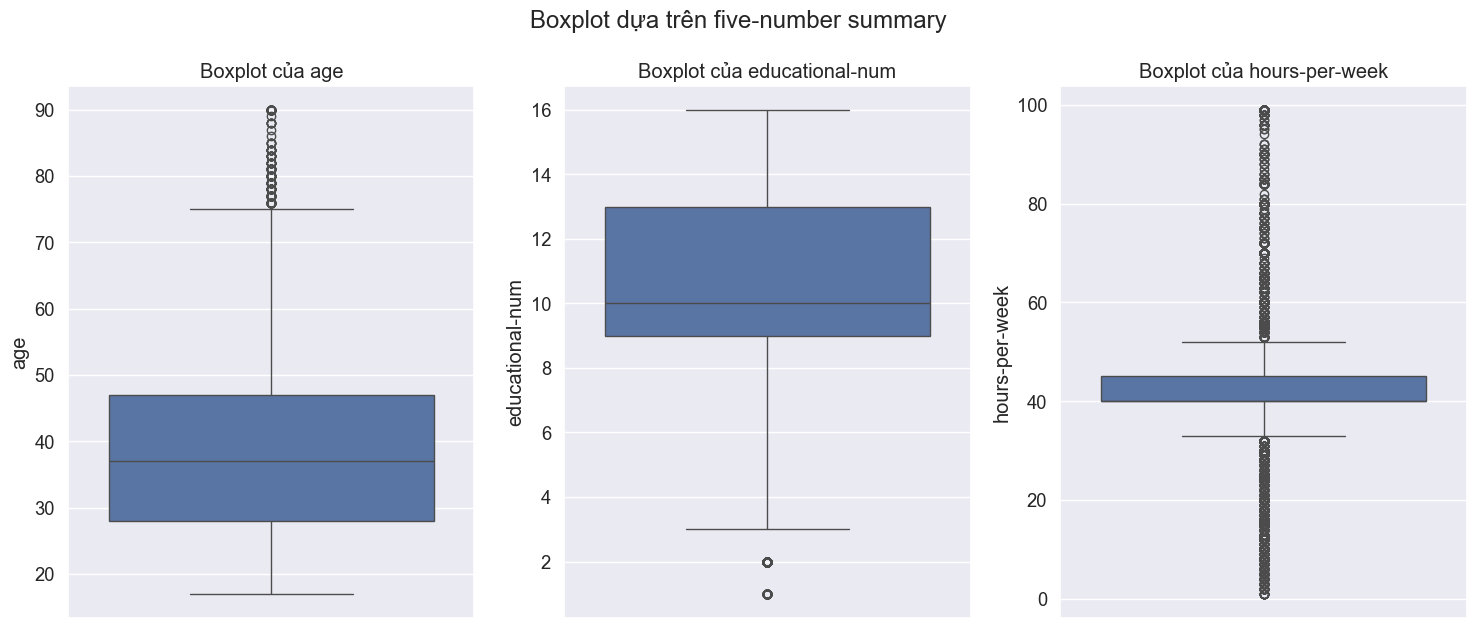

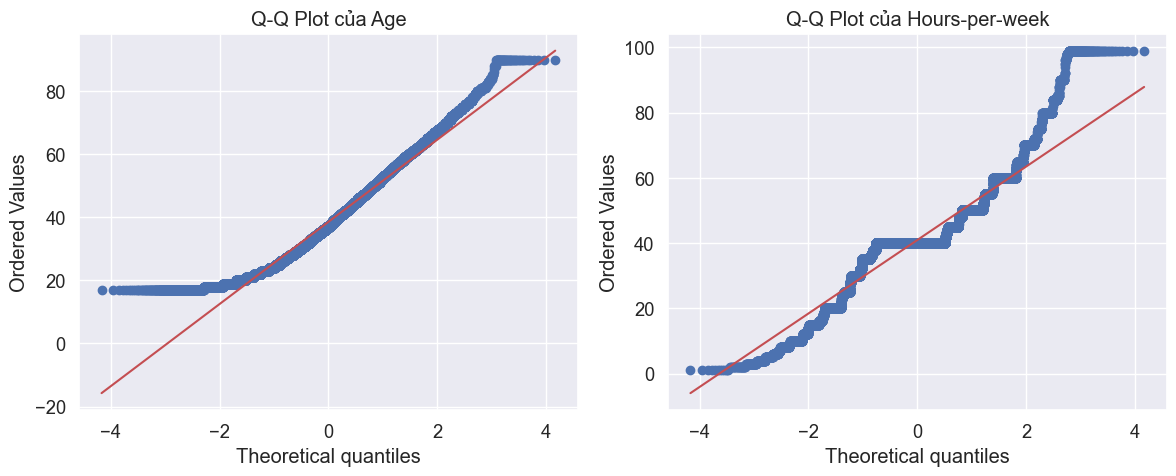

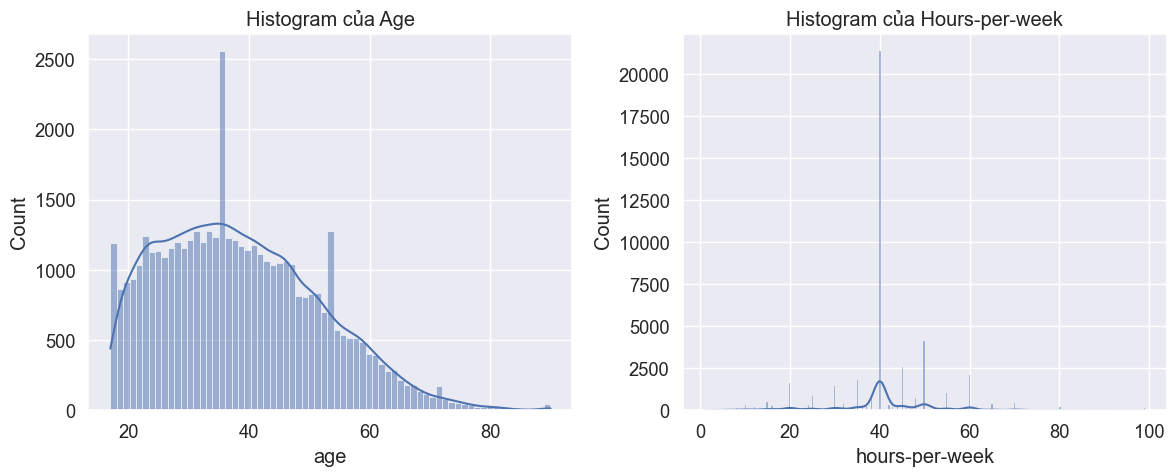

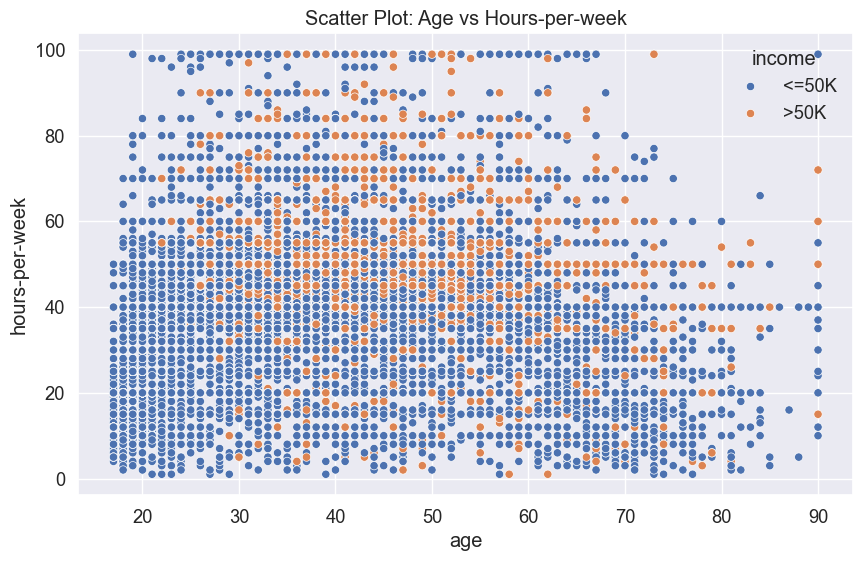

In [8]:
# 2.1.1. Vẽ các đồ thị phân tích cho ít nhất 3 thuộc tính
print("# 2.1.1. Phân tích đồ thị cho các thuộc tính\n")

# Chọn 3 thuộc tính số để phân tích
numeric_features = ['age', 'educational-num', 'hours-per-week']

# 1. Boxplot dựa trên five-number summary
plt.figure(figsize=(15, 6))
for i, feature in enumerate(numeric_features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[feature])
    plt.title(f'Boxplot của {feature}')
    plt.tight_layout()
plt.suptitle('Boxplot dựa trên five-number summary', y=1.05)
plt.show()

# 2. Quantile-Quantile Plot cho 2 thuộc tính
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
stats.probplot(df['age'], dist="norm", plot=plt)
plt.title('Q-Q Plot của Age')

plt.subplot(1, 2, 2)
stats.probplot(df['hours-per-week'], dist="norm", plot=plt)
plt.title('Q-Q Plot của Hours-per-week')
plt.tight_layout()
plt.show()

# 3. Histogram trên 2 thuộc tính
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['age'], kde=True)
plt.title('Histogram của Age')

plt.subplot(1, 2, 2)
sns.histplot(df['hours-per-week'], kde=True)
plt.title('Histogram của Hours-per-week')
plt.tight_layout()
plt.show()

# 4. Scatter plot trên 2 thuộc tính
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='hours-per-week', hue='income', data=df)
plt.title('Scatter Plot: Age vs Hours-per-week')
plt.show()

# 2.1.2. Nhóm dữ liệu theo thuộc tính danh nghĩa



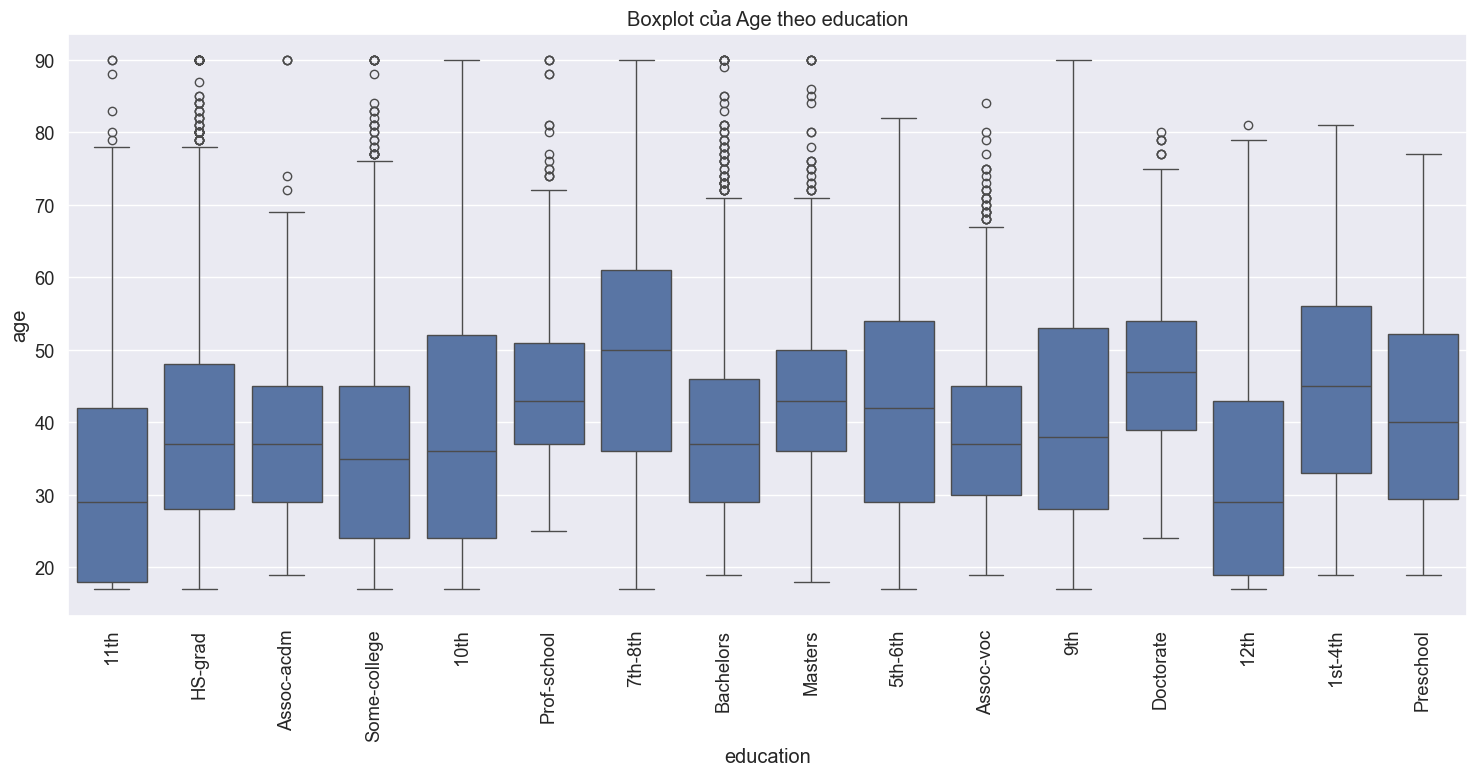

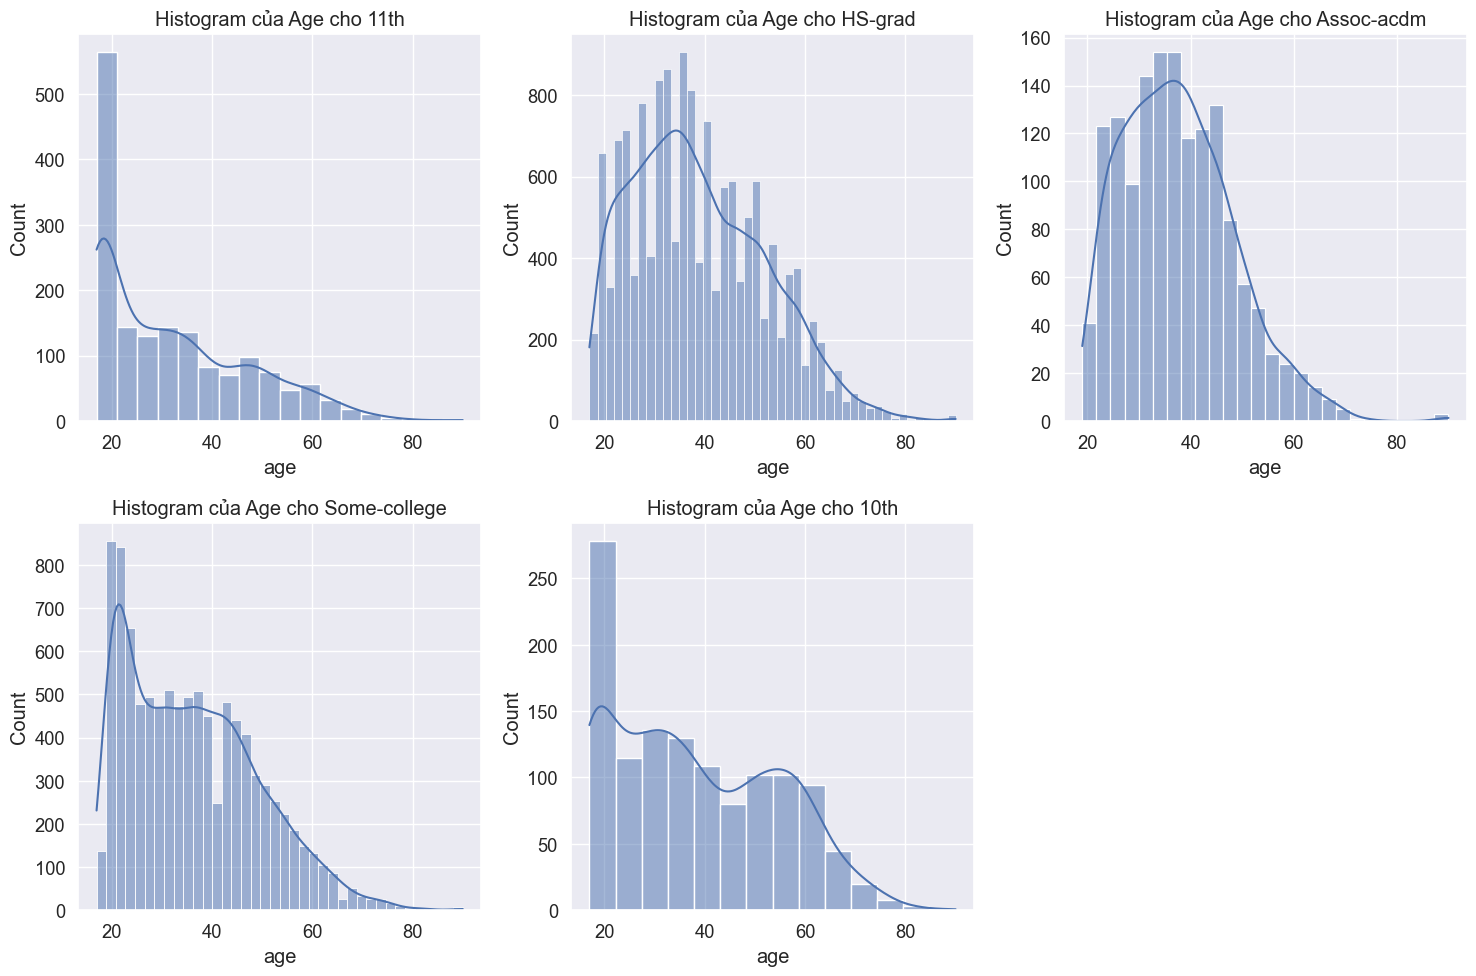

In [9]:
# 2.1.2. Nhóm dữ liệu theo thuộc tính danh nghĩa và vẽ biểu đồ
print("# 2.1.2. Nhóm dữ liệu theo thuộc tính danh nghĩa\n")

# Chọn thuộc tính danh nghĩa để nhóm dữ liệu
grouping_feature = 'education'

# 1. Boxplot dựa trên five-number summary cho dữ liệu đã nhóm
plt.figure(figsize=(15, 8))
sns.boxplot(x=grouping_feature, y='age', data=df)
plt.title(f'Boxplot của Age theo {grouping_feature}')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 2. Histogram cho dữ liệu đã nhóm
education_groups = df[grouping_feature].unique()
selected_groups = education_groups[:5]  # Chọn 5 nhóm đầu tiên để minh họa

plt.figure(figsize=(15, 10))
for i, group in enumerate(selected_groups):
    plt.subplot(2, 3, i+1)
    group_data = df[df[grouping_feature] == group]
    sns.histplot(group_data['age'], kde=True)
    plt.title(f'Histogram của Age cho {group}')
plt.tight_layout()
plt.show()

# 2.1.3. Đo lường sự tương đồng và khác biệt của dữ liệu

## Ma trận tương quan


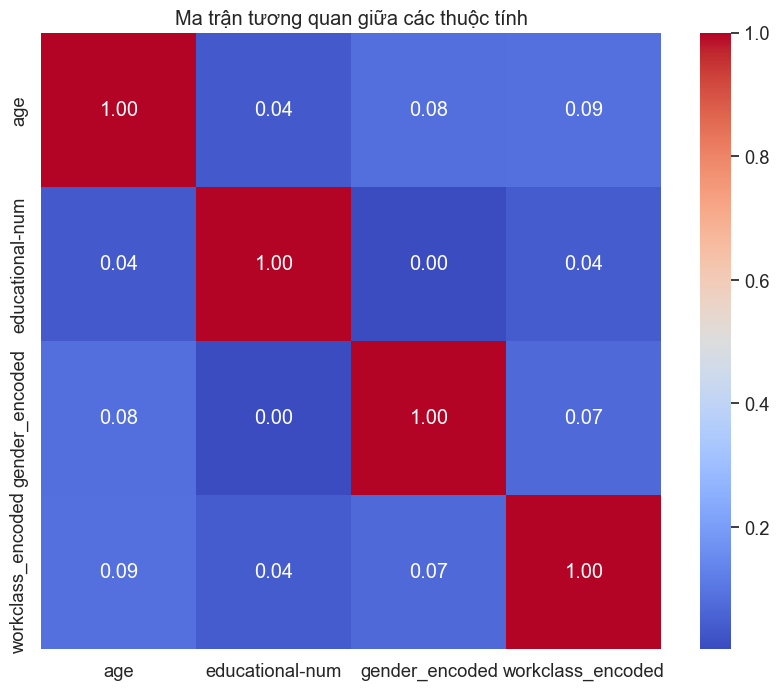


## Độ đo Cosine
4 dòng dữ liệu đầu tiên:
   age  educational-num  gender_encoded  workclass_encoded
0   25                7               1                  2
1   38                9               1                  2
2   28               12               1                  1
3   44               10               1                  2

Ma trận độ đo Cosine:
[[1.         0.99877388 0.99037204 0.99811706]
 [0.99877388 1.         0.98503277 0.99992939]
 [0.99037204 0.98503277 1.         0.98350443]
 [0.99811706 0.99992939 0.98350443 1.        ]]


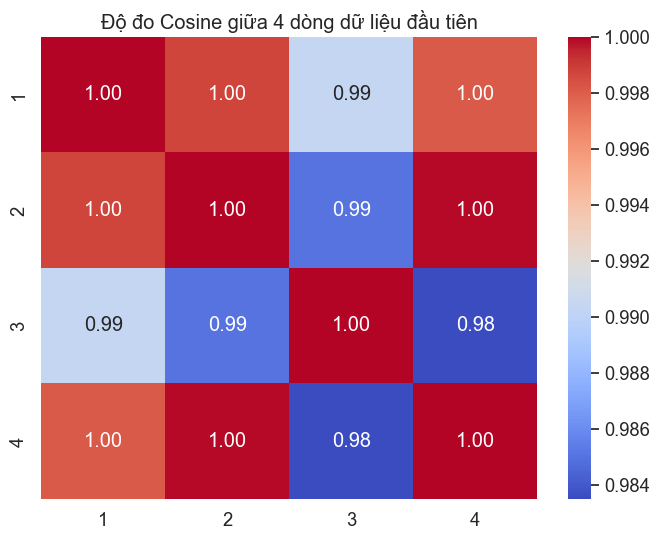


## So sánh kết quả của 2 phương pháp đo lường

Ma trận tương quan đo lường mối quan hệ tuyến tính giữa các thuộc tính, trong khi độ đo Cosine đo lường 
sự tương đồng giữa các vector (dòng dữ liệu). 

- Ma trận tương quan cho thấy mức độ tương quan giữa các cặp thuộc tính, giá trị từ -1 đến 1.
- Độ đo Cosine cho thấy sự tương đồng giữa các dòng dữ liệu, giá trị từ 0 đến 1 (1 là hoàn toàn giống nhau).

Từ kết quả trên, chúng ta có thể thấy:
1. Các thuộc tính có mối tương quan khác nhau, với một số cặp có tương quan mạnh hơn các cặp khác.
2. Các dòng dữ liệu có độ tương đồng khác nhau, với một số cặp dòng tương đồng hơn các cặp khác.



In [10]:
# 2.1.3. Đo lường sự tương đồng và khác biệt của dữ liệu
print("# 2.1.3. Đo lường sự tương đồng và khác biệt của dữ liệu\n")

# Chọn 4 thuộc tính thuộc các dạng dữ liệu khác nhau
# Nominal: workclass
# Binary: gender_encoded
# Numeric: age
# Ordinal: educational-num

# Ma trận tương quan
print("## Ma trận tương quan")
selected_features = ['age', 'educational-num', 'gender_encoded', 'workclass_encoded']
correlation_matrix = df_numeric[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan giữa các thuộc tính')
plt.show()

# Độ đo Cosine
print("\n## Độ đo Cosine")
from sklearn.metrics.pairwise import cosine_similarity

# Chọn 4 dòng dữ liệu đầu tiên
sample_data = df_numeric[selected_features].head(4)
print("4 dòng dữ liệu đầu tiên:")
print(sample_data)

# Tính độ đo cosine
cosine_sim = cosine_similarity(sample_data)
print("\nMa trận độ đo Cosine:")
print(cosine_sim)

# Hiển thị kết quả dưới dạng heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim, annot=True, cmap='coolwarm', fmt='.2f',
            xticklabels=range(1, 5), yticklabels=range(1, 5))
plt.title('Độ đo Cosine giữa 4 dòng dữ liệu đầu tiên')
plt.show()

# So sánh kết quả của 2 phương pháp
print("\n## So sánh kết quả của 2 phương pháp đo lường")
print("""
Ma trận tương quan đo lường mối quan hệ tuyến tính giữa các thuộc tính, trong khi độ đo Cosine đo lường 
sự tương đồng giữa các vector (dòng dữ liệu). 

- Ma trận tương quan cho thấy mức độ tương quan giữa các cặp thuộc tính, giá trị từ -1 đến 1.
- Độ đo Cosine cho thấy sự tương đồng giữa các dòng dữ liệu, giá trị từ 0 đến 1 (1 là hoàn toàn giống nhau).

Từ kết quả trên, chúng ta có thể thấy:
1. Các thuộc tính có mối tương quan khác nhau, với một số cặp có tương quan mạnh hơn các cặp khác.
2. Các dòng dữ liệu có độ tương đồng khác nhau, với một số cặp dòng tương đồng hơn các cặp khác.
""")

In [11]:
# 2.2. Tiền xử lý dữ liệu (bổ sung)
print("# 2.2. Tiền xử lý dữ liệu (bổ sung)\n")

# Chuẩn hóa dữ liệu
print("## Chuẩn hóa dữ liệu")
numeric_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Sử dụng StandardScaler
scaler = StandardScaler()
df_scaled = df_numeric.copy()
df_scaled[numeric_features] = scaler.fit_transform(df_scaled[numeric_features])

print("Dữ liệu sau khi chuẩn hóa (5 dòng đầu tiên):")
df_scaled.head()

# 2.2. Tiền xử lý dữ liệu (bổ sung)

## Chuẩn hóa dữ liệu
Dữ liệu sau khi chuẩn hóa (5 dòng đầu tiên):


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_encoded,income_encoded,workclass_encoded,education_encoded,marital-status_encoded,occupation_encoded,relationship_encoded,race_encoded,gender_encoded,native-country_encoded
0,-1.024983,0.350889,-1.221559,-0.146733,-0.21878,-0.078120,0,0,2,1,4,6,3,2,1,38
1,-0.041455,-0.945878,-0.438122,-0.146733,-0.21878,0.754701,0,0,2,11,2,4,0,4,1,38
2,-0.798015,1.393592,0.737034,-0.146733,-0.21878,-0.078120,1,1,1,7,2,10,0,4,1,38
3,0.412481,-0.278420,-0.046403,0.877467,-0.21878,-0.078120,1,1,2,15,2,6,0,2,1,38
5,-0.344079,0.084802,-1.613277,-0.146733,-0.21878,-0.910942,0,0,2,0,4,7,1,4,1,38


In [12]:
# 2.3. Tổng hợp dữ liệu
print("# 2.3. Tổng hợp dữ liệu\n")

# Tổng hợp dữ liệu theo giới tính và thu nhập
gender_income = df.groupby(['gender', 'income']).size().unstack()
print("## Tổng hợp theo giới tính và thu nhập:")
print(gender_income)

# Tính tỷ lệ phần trăm
gender_income_pct = gender_income.div(gender_income.sum(axis=1), axis=0) * 100
print("\n## Tỷ lệ phần trăm thu nhập theo giới tính:")
print(gender_income_pct)

# Tổng hợp dữ liệu theo trình độ học vấn và thu nhập
education_income = df.groupby(['education', 'income']).size().unstack()
print("\n## Tổng hợp theo trình độ học vấn và thu nhập:")
print(education_income)

# Tính tỷ lệ phần trăm
education_income_pct = education_income.div(education_income.sum(axis=1), axis=0) * 100
print("\n## Tỷ lệ phần trăm thu nhập theo trình độ học vấn:")
print(education_income_pct)

# Tổng hợp thống kê theo nhóm
print("\n## Thống kê tuổi và giờ làm việc theo thu nhập:")
income_stats = df.groupby('income')[['age', 'hours-per-week']].agg(['mean', 'median', 'min', 'max'])
print(income_stats)

# 2.3. Tổng hợp dữ liệu

## Tổng hợp theo giới tính và thu nhập:
income  <=50K  >50K
gender             
Female  13026  1669
Male    20988  9539

## Tỷ lệ phần trăm thu nhập theo giới tính:
income      <=50K       >50K
gender                      
Female  88.642395  11.357605
Male    68.752252  31.247748

## Tổng hợp theo trình độ học vấn và thu nhập:
income        <=50K  >50K
education                
10th           1141    82
11th           1530    89
12th            534    43
1st-4th         214     8
5th-6th         427    22
7th-8th         768    55
9th             638    38
Assoc-acdm     1109   398
Assoc-voc      1455   504
Bachelors      4392  3178
Doctorate       145   399
HS-grad       12367  2416
Masters        1121  1393
Preschool        71     1
Prof-school     193   592
Some-college   7909  1990

## Tỷ lệ phần trăm thu nhập theo trình độ học vấn:
income            <=50K       >50K
education                         
10th          93.295176   6.704824
11th          94.5027

# 2.4. Trực quan hóa dữ liệu



<Figure size 1000x600 with 0 Axes>

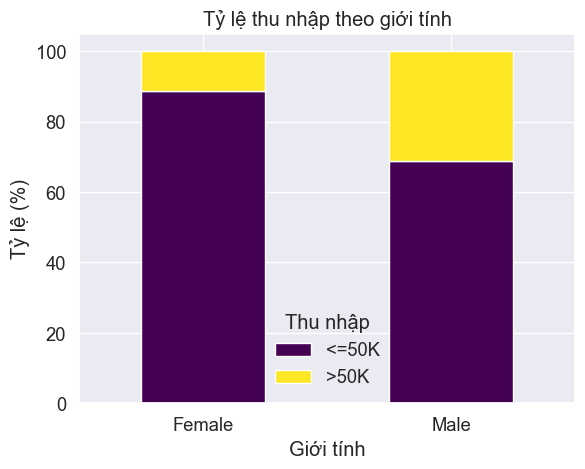

<Figure size 1400x800 with 0 Axes>

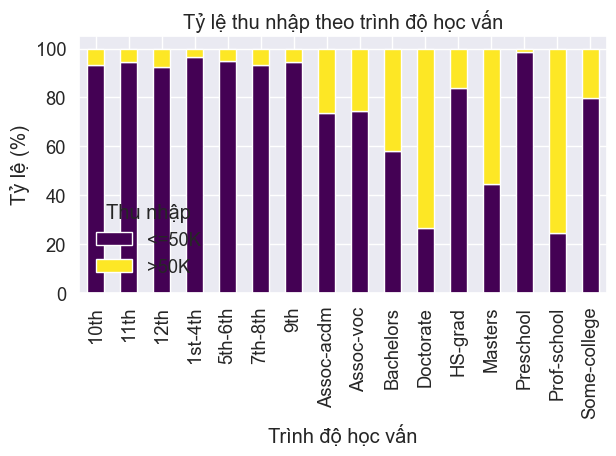

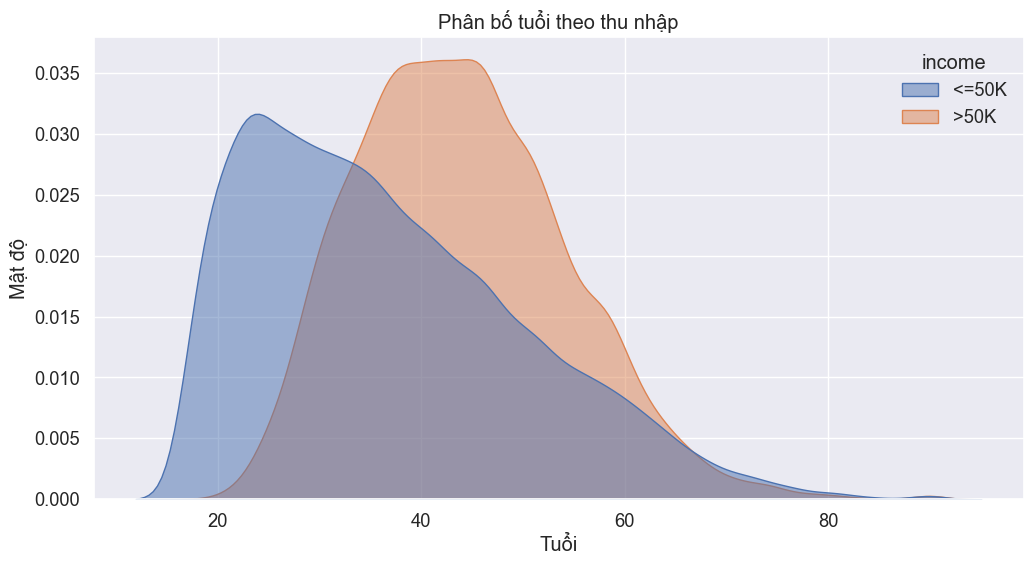

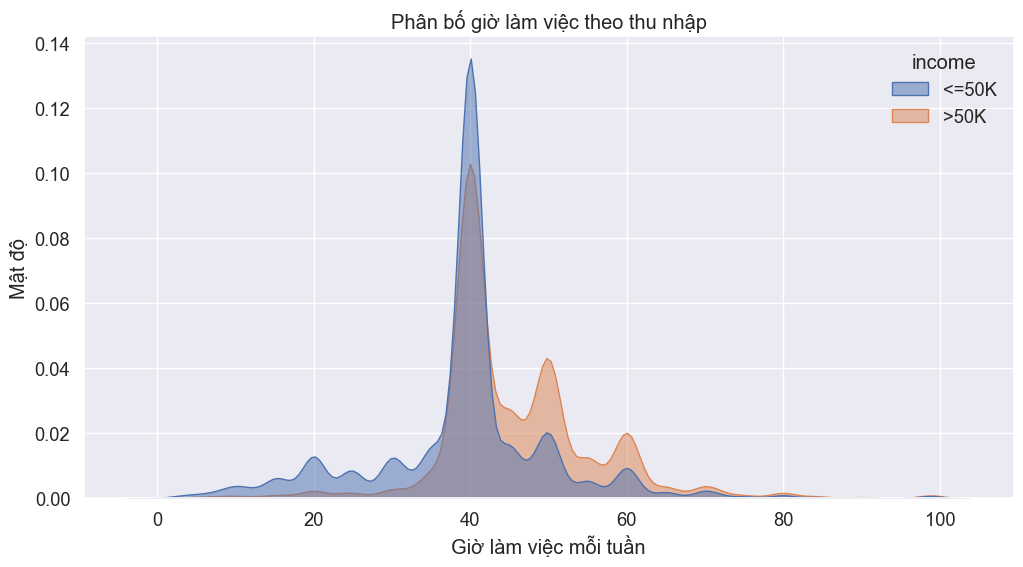

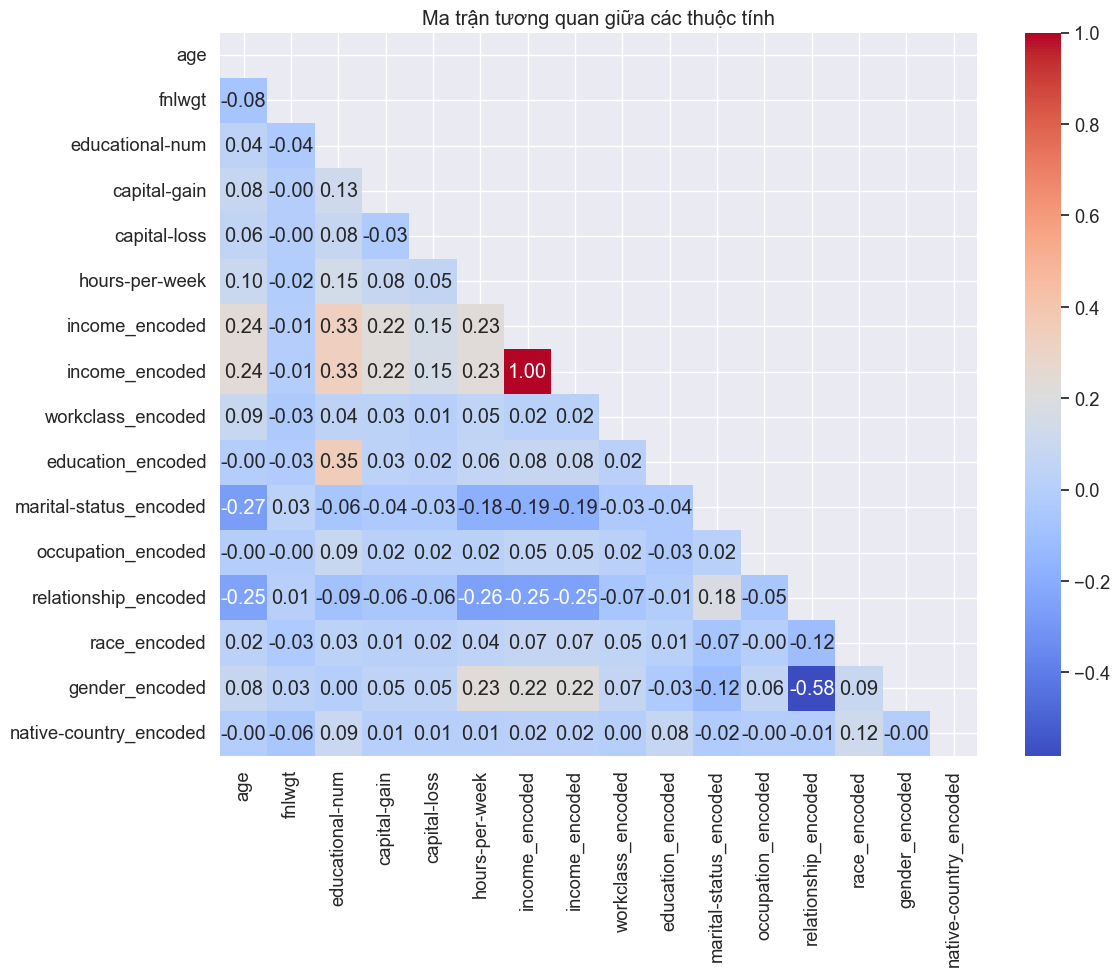

In [13]:
# 2.4. Trực quan hóa dữ liệu
print("# 2.4. Trực quan hóa dữ liệu\n")

# Biểu đồ tỷ lệ thu nhập theo giới tính
plt.figure(figsize=(10, 6))
gender_income_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Tỷ lệ thu nhập theo giới tính')
plt.xlabel('Giới tính')
plt.ylabel('Tỷ lệ (%)')
plt.xticks(rotation=0)
plt.legend(title='Thu nhập')
plt.show()

# Biểu đồ tỷ lệ thu nhập theo trình độ học vấn
plt.figure(figsize=(14, 8))
education_income_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Tỷ lệ thu nhập theo trình độ học vấn')
plt.xlabel('Trình độ học vấn')
plt.ylabel('Tỷ lệ (%)')
plt.xticks(rotation=90)
plt.legend(title='Thu nhập')
plt.tight_layout()
plt.show()

# Biểu đồ phân bố tuổi theo thu nhập
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='age', hue='income', fill=True, common_norm=False, alpha=0.5)
plt.title('Phân bố tuổi theo thu nhập')
plt.xlabel('Tuổi')
plt.ylabel('Mật độ')
plt.show()

# Biểu đồ phân bố giờ làm việc theo thu nhập
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='hours-per-week', hue='income', fill=True, common_norm=False, alpha=0.5)
plt.title('Phân bố giờ làm việc theo thu nhập')
plt.xlabel('Giờ làm việc mỗi tuần')
plt.ylabel('Mật độ')
plt.show()

# Biểu đồ tương quan giữa các thuộc tính
plt.figure(figsize=(12, 10))
correlation = df_numeric.corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Ma trận tương quan giữa các thuộc tính')
plt.tight_layout()
plt.show()

# 2.5. Thực hiện khai thác dữ liệu

## 2.5.1. Sử dụng các phương pháp khai phá dữ liệu

Kích thước df: (45222, 16)
Các cột trong df: ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income', 'income_encoded']
Các lớp của biến mục tiêu: ['<=50K' '>50K']
Mã hóa thành: [0 1]
Kích thước X: (45222, 96)
Kích thước y: (45222,)
Kích thước dữ liệu sau khi chia:
X_train: (31655, 96)
X_test: (13567, 96)
y_train: (31655,)
y_test: (13567,)

### Phương pháp 1: Phân lớp với Decision Tree
Độ chính xác trên tập kiểm tra: 0.8097589739809833

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87     10241
           1       0.61      0.62      0.62      3326

    accuracy                           0.81     13567
   macro avg       0.74      0.75      0.74     13567
weighted avg       0.81      0

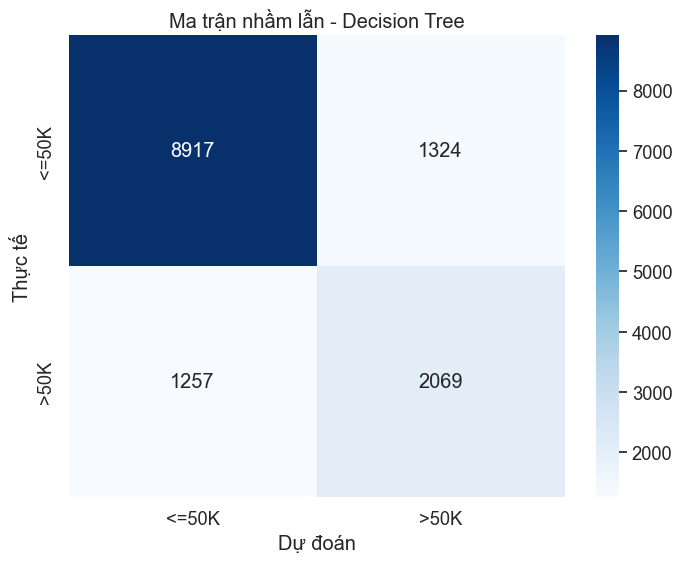


### Phương pháp 2: Phân lớp với Random Forest
Độ chính xác trên tập kiểm tra: 0.851256725878971

Báo cáo phân loại:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10241
           1       0.73      0.62      0.67      3326

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.85      0.85      0.85     13567


Ma trận nhầm lẫn:
[[9473  768]
 [1250 2076]]


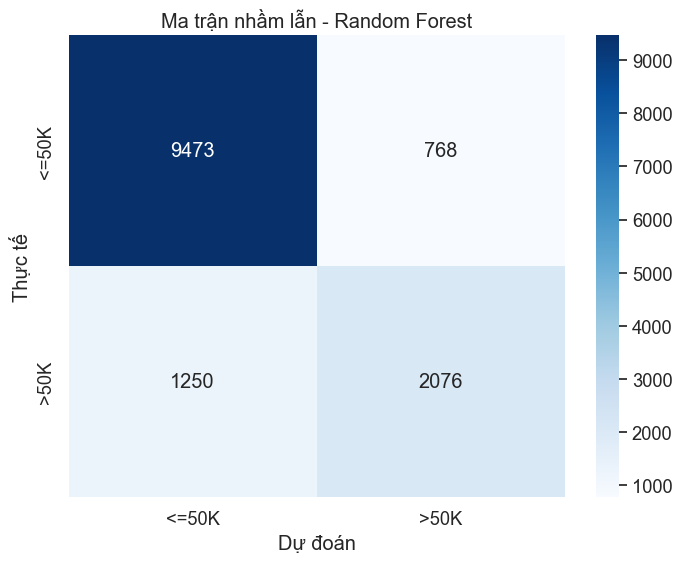


### Phương pháp 3: Phân cụm với K-means


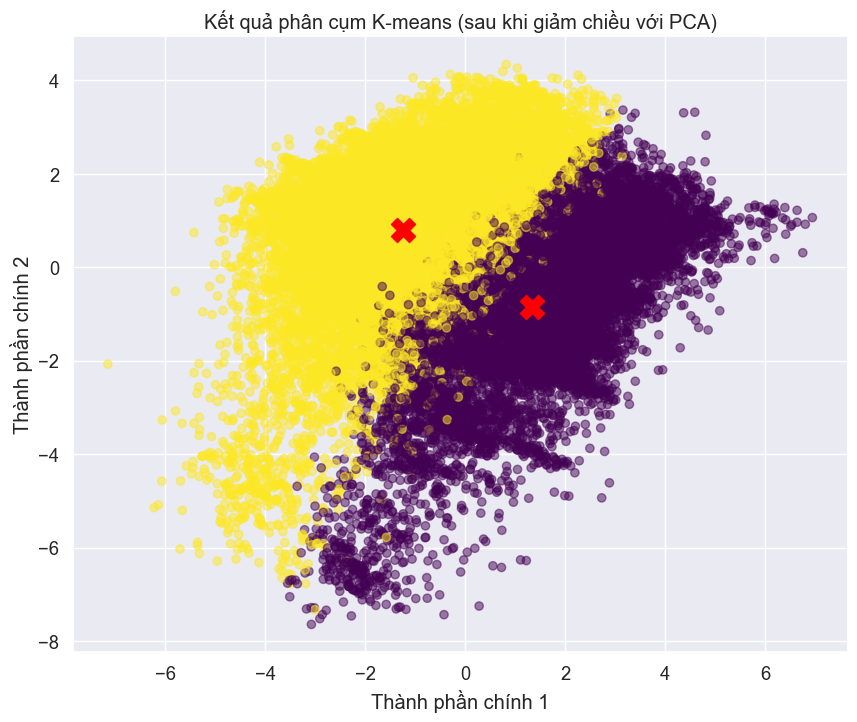


Bảng liên hợp giữa cụm và thu nhập thực tế:
Income       0     1
Cluster             
0        11934  9867
1        22080  1341

Tỷ lệ phần trăm thu nhập trong mỗi cụm:
Income           0          1
Cluster                      
0        54.740608  45.259392
1        94.274369   5.725631


In [14]:
# 2.5. Thực hiện khai thác dữ liệu
print("# 2.5. Thực hiện khai thác dữ liệu\n")

# 2.5.1. Sử dụng các phương pháp khai phá dữ liệu
print("## 2.5.1. Sử dụng các phương pháp khai phá dữ liệu\n")

# Kiểm tra dữ liệu
print(f"Kích thước df: {df.shape}")
print(f"Các cột trong df: {df.columns.tolist()}")

# Tạo lại dữ liệu đầu vào cho mô hình từ đầu
# Chọn các cột số
numeric_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
X_numeric = df[numeric_cols].copy()

# Mã hóa các cột phân loại (trừ cột mục tiêu 'income')
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 
                    'relationship', 'race', 'gender', 'native-country']
X_categorical = pd.DataFrame()

for col in categorical_cols:
    # Tạo biến dummy cho mỗi cột phân loại
    dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
    X_categorical = pd.concat([X_categorical, dummies], axis=1)

# Kết hợp các đặc trưng số và phân loại đã mã hóa
X = pd.concat([X_numeric, X_categorical], axis=1)

# Mã hóa biến mục tiêu
le = LabelEncoder()
y = le.fit_transform(df['income'])
print(f"Các lớp của biến mục tiêu: {le.classes_}")
print(f"Mã hóa thành: {np.unique(y)}")

# Kiểm tra kích thước
print(f"Kích thước X: {X.shape}")
print(f"Kích thước y: {y.shape}")

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Kích thước dữ liệu sau khi chia:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Phương pháp 1: Phân lớp với Decision Tree
print("\n### Phương pháp 1: Phân lớp với Decision Tree")
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_dt = dt_model.predict(X_test)

# Đánh giá mô hình
print("Độ chính xác trên tập kiểm tra:", accuracy_score(y_test, y_pred_dt))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_dt))

# Tạo ma trận nhầm lẫn
print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Decision Tree')
plt.show()

# Phương pháp 2: Phân lớp với Random Forest
print("\n### Phương pháp 2: Phân lớp với Random Forest")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

# Đánh giá mô hình
print("Độ chính xác trên tập kiểm tra:", accuracy_score(y_test, y_pred_rf))
print("\nBáo cáo phân loại:")
print(classification_report(y_test, y_pred_rf))

# Tạo ma trận nhầm lẫn
print("\nMa trận nhầm lẫn:")
cm = confusion_matrix(y_test, y_pred_rf)
print(cm)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.title('Ma trận nhầm lẫn - Random Forest')
plt.show()

# Phương pháp 3: Phân cụm với K-means
print("\n### Phương pháp 3: Phân cụm với K-means")

# Chuẩn hóa dữ liệu cho phân cụm
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Áp dụng K-means với k=2 (tương ứng với 2 nhóm thu nhập)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Giảm chiều dữ liệu để trực quan hóa
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Trực quan hóa kết quả phân cụm
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)

# Chuyển đổi tâm cụm sang không gian PCA
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=300, c='red', marker='X')

plt.title('Kết quả phân cụm K-means (sau khi giảm chiều với PCA)')
plt.xlabel('Thành phần chính 1')
plt.ylabel('Thành phần chính 2')
plt.show()

# So sánh kết quả phân cụm với nhãn thực tế
cluster_df = pd.DataFrame({'Cluster': clusters, 'Income': y})
contingency_table = pd.crosstab(cluster_df['Cluster'], cluster_df['Income'])
print("\nBảng liên hợp giữa cụm và thu nhập thực tế:")
print(contingency_table)

# Tính tỷ lệ phần trăm
contingency_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
print("\nTỷ lệ phần trăm thu nhập trong mỗi cụm:")
print(contingency_pct)

## 2.5.2. Đánh giá các mẫu thu được

### Phương pháp đánh giá 1: Cross-Validation
Decision Tree - Độ chính xác qua 5-fold CV: [0.81437258 0.81304588 0.80473242 0.81048209 0.81258293]
Độ chính xác trung bình: 0.8110, Độ lệch chuẩn: 0.0034

Random Forest - Độ chính xác qua 5-fold CV: [0.85406302 0.85715865 0.85084034 0.84785493 0.84851835]
Độ chính xác trung bình: 0.8517, Độ lệch chuẩn: 0.0035

### Phương pháp đánh giá 2: Đường cong ROC


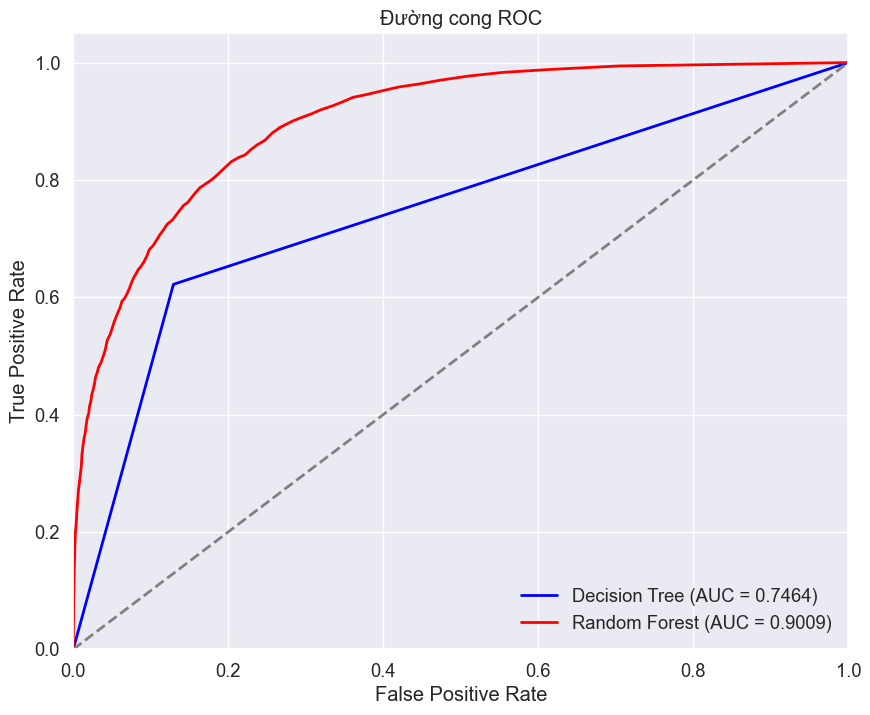


## So sánh kết quả của 2 phương pháp đánh giá

Từ kết quả đánh giá, chúng ta có thể thấy:

1. Cross-Validation:
   - Decision Tree có độ chính xác trung bình là 0.8110
   - Random Forest có độ chính xác trung bình là 0.8517
   - Random Forest có độ chính xác cao hơn và ổn định hơn (độ lệch chuẩn thấp hơn)

2. Đường cong ROC:
   - Decision Tree có AUC = 0.7464
   - Random Forest có AUC = 0.9009
   - Random Forest có khả năng phân biệt tốt hơn giữa các lớp

Kết luận:
- Random Forest cho kết quả tốt hơn Decision Tree trong cả hai phương pháp đánh giá
- Phương pháp phân cụm K-means đã phân chia dữ liệu thành 2 cụm, nhưng sự phân chia này không hoàn toàn tương ứng với phân loại thu nhập thực tế
- Các mô hình phân lớp (Decision Tree và Random Forest) hiệu quả hơn trong việc dự đoán thu nhập so với phương pháp phân cụm không giám sát



In [15]:
# 2.5.2. Đánh giá các mẫu thu được
print("## 2.5.2. Đánh giá các mẫu thu được\n")

# Phương pháp đánh giá 1: Cross-Validation
print("### Phương pháp đánh giá 1: Cross-Validation")
# Thực hiện 5-fold cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Đánh giá Decision Tree
dt_scores = cross_val_score(dt_model, X, y, cv=cv, scoring='accuracy')
print("Decision Tree - Độ chính xác qua 5-fold CV:", dt_scores)
print(f"Độ chính xác trung bình: {dt_scores.mean():.4f}, Độ lệch chuẩn: {dt_scores.std():.4f}")

# Đánh giá Random Forest
rf_scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print("\nRandom Forest - Độ chính xác qua 5-fold CV:", rf_scores)
print(f"Độ chính xác trung bình: {rf_scores.mean():.4f}, Độ lệch chuẩn: {rf_scores.std():.4f}")

# Phương pháp đánh giá 2: Đường cong ROC
print("\n### Phương pháp đánh giá 2: Đường cong ROC")

# Tính xác suất dự đoán cho Decision Tree
y_prob_dt = dt_model.predict_proba(X_test)[:, 1]
# Tính xác suất dự đoán cho Random Forest
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Tính toán đường cong ROC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

# Tính diện tích dưới đường cong ROC (AUC)
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Vẽ đường cong ROC
plt.figure(figsize=(10, 8))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.4f})')
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Đường cong ROC')
plt.legend(loc="lower right")
plt.show()

# So sánh kết quả của 2 phương pháp đánh giá
print("\n## So sánh kết quả của 2 phương pháp đánh giá")
print(f"""
Từ kết quả đánh giá, chúng ta có thể thấy:

1. Cross-Validation:
   - Decision Tree có độ chính xác trung bình là {dt_scores.mean():.4f}
   - Random Forest có độ chính xác trung bình là {rf_scores.mean():.4f}
   - Random Forest có độ chính xác cao hơn và ổn định hơn (độ lệch chuẩn thấp hơn)

2. Đường cong ROC:
   - Decision Tree có AUC = {roc_auc_dt:.4f}
   - Random Forest có AUC = {roc_auc_rf:.4f}
   - Random Forest có khả năng phân biệt tốt hơn giữa các lớp

Kết luận:
- Random Forest cho kết quả tốt hơn Decision Tree trong cả hai phương pháp đánh giá
- Phương pháp phân cụm K-means đã phân chia dữ liệu thành 2 cụm, nhưng sự phân chia này không hoàn toàn tương ứng với phân loại thu nhập thực tế
- Các mô hình phân lớp (Decision Tree và Random Forest) hiệu quả hơn trong việc dự đoán thu nhập so với phương pháp phân cụm không giám sát
""")